In [5]:
using Plots

In [6]:
using Statistics
using NiLang



In [7]:
#提取日线沪深300指数收盘价
a= readlines("F:\\我的坚果云\\julia\\策略微分\\data.txt");
b=parse.(Float64,a);


In [83]:
#EMA权重
bili=0.0952;
n=length(b);
ma=zeros(n,1);
ma[1]=b[1];
pos=zeros(n,1);
#单位净值
jinzhi=ones(n,1);
for i =2:n
    if pos[i-1]>0
        #如果信号为正,做多
        jinzhi[i]=jinzhi[i-1]*(b[i]/b[i-1]);
    elseif pos[i-1]<0
        #如果信号为负,做空
        jinzhi[i]=jinzhi[i-1]*(2-b[i]/b[i-1]);
    else
        #如果信号为0,保持不变
        jinzhi[i]=jinzhi[i-1];
    end
    #计算EMA
    ma[i]=b[i]*bili+(1-bili)*ma[i-1];

    pos[i] = -tanh(ma[i]-b[i]);

end


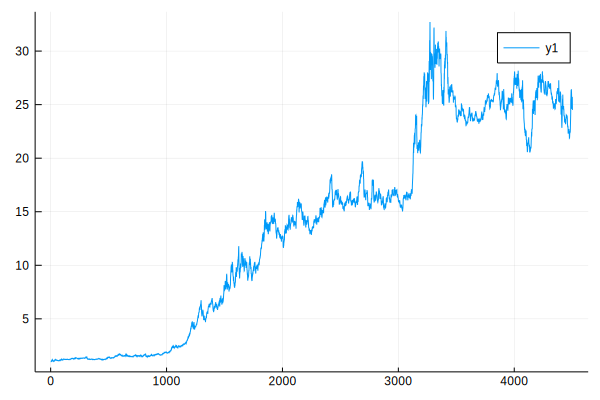

In [85]:
plot(jinzhi)

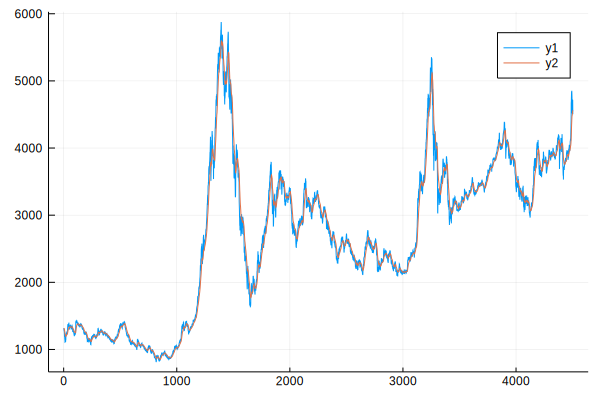

In [12]:
plot(b)
plot!(ma)

In [63]:
@i function jin(out::T,b::AbstractVector{T},ma::AbstractVector{T},jinzhi::AbstractVector{T},pos::AbstractVector{T},bili::T) where T
    @routine begin
        for i =2:length(b)

            if (pos[i-1]!=0, ~)
                @routine begin
                    # use `@zeros TYPE vars...` to add ancillas
                    @zeros T anc1 anc2
                    # !note: one operations a time, it should be `y += f(x)` or `y += x`.
                    anc1 += b[i] / b[i-1]
                    anc1 -= 1.0
                    anc2 += anc1 * pos[i-1]
                    #anc2 += 1.0
                end

                jinzhi[i] += anc2
                jinzhi[i] -= 0.0001
                ~@routine
            end

            ma[i] += b[i] * bili
            bili -= 1.0
            ma[i] -= bili * ma[i-1]
            bili += 1.0


            # the relaxed version
            ma[i] -= b[i]
            pos[i] -= tanh(ma[i])
            ma[i] += b[i]
        end
        @zeros T var varsum mean sum std
        NiLang.i_var_mean_sum(var, varsum, mean, sum, jinzhi)
        std += sqrt(var)
    end
    #计算夏普率
    out += mean/std 
    ~@routine
end
    

In [78]:
bili=0.0952;
n=length(b);
ma=zeros(n);
ma[1]=b[1];
jinzhi=zeros(n);
#jinzhi[1]=1.0;
pos=zeros(n);
out=0.0;
# check the reversibility
check_inv(jin, (out,b,ma,jinzhi,pos,bili))


true

In [65]:
# check the gradients with numeric gradients
NiLang.AD.check_grad(jin, (out,b,ma,jinzhi,pos,bili); iloss=1)

false

In [68]:
out,b,ma,jinzhi,pos,bili=jin(out,b,ma,jinzhi,pos,bili)


(0.04168701867766251, [1316.4600000000005, 1302.0800000000004, 1292.7100000000005, 1272.6500000000005, 1281.2600000000004, 1249.8100000000004, 1205.1500000000005, 1186.4300000000005, 1201.8800000000006, 1152.1500000000005  …  4806.69, 4744.47, 4516.25, 4544.7, 4680.3, 4691.04, 4714.45, 4712.44, 4505.59, 4512.86], [1316.4600000000005, 7.105427357601002e-14, 7.105427357601002e-14, -7.105427357601002e-14, 2.842170943040401e-14, -1.4210854715202004e-14, 0.0, -1.4210854715202004e-14, -7.105427357601002e-14, 7.105427357601002e-14  …  2.8421709430404007e-13, 0.0, 3.410605131648481e-13, 2.2737367544323206e-13, -4.547473508864641e-13, 2.2737367544323206e-13, 5.684341886080802e-14, 2.2737367544323206e-13, -4.547473508864641e-13, 2.8421709430404007e-13], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.421010862427522e-20, 0.0, -2.168404344971009e-19], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [69]:
out,b,ma,jinzhi,pos,bili=(~jin)(out,b,ma,jinzhi,pos,bili)

(0.0, [1316.4600000000005, 1302.0800000000004, 1292.7100000000005, 1272.6500000000005, 1281.2600000000004, 1249.8100000000004, 1205.1500000000005, 1186.4300000000005, 1201.8800000000006, 1152.1500000000005  …  4806.69, 4744.47, 4516.25, 4544.7, 4680.3, 4691.04, 4714.45, 4712.44, 4505.59, 4512.86], [1316.4600000000005, 7.105427357601002e-14, 7.105427357601002e-14, -7.105427357601002e-14, 2.842170943040401e-14, -1.4210854715202004e-14, 0.0, -1.4210854715202004e-14, -7.105427357601002e-14, 7.105427357601002e-14  …  2.8421709430404007e-13, 0.0, 3.410605131648481e-13, 2.2737367544323206e-13, -4.547473508864641e-13, 2.2737367544323206e-13, 5.684341886080802e-14, 2.2737367544323206e-13, -4.547473508864641e-13, 2.8421709430404007e-13], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.421010862427522e-20, 0.0, -2.168404344971009e-19], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0.095199999999

In [70]:
gout,gb,gma,gjinzhi,gpos,gbili= NiLang.AD.gradient(Val(1), jin, (out,b,ma,jinzhi,pos,bili))

(1.0, [0.0, 9.70553516963729e-6, -6.847015751764961e-7, 3.938910345542789e-7, -1.609396975662423e-6, -9.251139446527825e-7, 1.8546344682093917e-7, 4.963987894760628e-7, -2.7948391355926335e-6, 7.7117183816091e-7  …  -1.386372943192499e-8, -1.351696886891741e-7, 2.2754401660084996e-7, 1.1144809994081474e-7, -1.2583705746871731e-7, 1.1806265842067007e-8, -2.3500668723716127e-8, -1.734595017414186e-7, 6.161654779227281e-6, -2.992781310884909e-6], [-3.319811477518023e-6, -3.6691108283797774e-6, -4.055162279262628e-6, -4.481832757805734e-6, -4.953396063003685e-6, -5.474575666449696e-6, -6.050592027464297e-6, -6.687214884465403e-6, -7.39082104825973e-6, -8.168458276149126e-6  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.013426447905362984, 0.013426447905362984, 0.013187095628062742, 0.012906409865163051, 0.013658016448535605, 0.012601885542665212, 0.012224541405024212, 0.01290588543892815, 0.01386905836993123, 0.01203419058442661  …  0.013751413315478777, 0.013866434148782953, 0.

1 0.661760905924798
2 0.661945149961627
3 0.6621415673851906
4 0.6623514583662046
5 0.6625760205738773
6 0.6628162542616357
7 0.6630728606413469
8 0.6633461477809877
9 0.6636359626583834
10 0.6639416686422492
11 0.6642621827583358
12 0.6645960767734735
13 0.6649417330725932
14 0.6652975349336364
15 0.6656620652283586
16 0.6660342895447863
17 0.6664137079623755
18 0.6668004709242857
19 0.6671954654024232
20 0.6676003857491661
21 0.6680178090693034
22 0.6684512990622222
23 0.6689055677974186
24 0.6693867360022823
25 0.6699027563966743
26 0.6704641159904074
27 0.671085044852225
28 0.6717857096855061
29 0.6725964619298924
30 0.6735666786464373
31 0.674784512907993
32 0.6764230002232188
33 0.678836902323475
34 0.6825909340708085
35 0.6874746552406413
36 0.6916472062396081
37 0.694856656442187
38 0.6976835260377565
39 0.7003362970415355
40 0.7028288331680534
41 0.7051129282475458
42 0.7071400492705805
43 0.7088837971390055
44 0.7103413817407956
45 0.7115285421203756
46 0.7124736243936902
47 

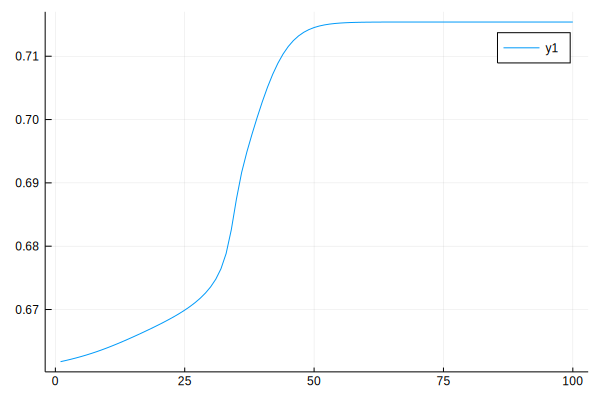

In [79]:
bili=0.0952;
steps=0.0001;
N=100;
sharpe=[];
for i=1:N

    out,b,ma,jinzhi,pos,bili=jin(out,b,ma,jinzhi,pos,bili);
    println(i," ",out*sqrt(252))
    push!(sharpe,out*sqrt(252))
    out,b,ma,jinzhi,pos,bili=(~jin)(out,b,ma,jinzhi,pos,bili);
    gout,gb,gma,gjinzhi,gpos,gbili= NiLang.AD.gradient(Val(1), jin, (out,b,ma,jinzhi,pos,bili));
    bili+=gbili*steps;

end

print(bili)
plot(sharpe)




In [21]:
@i function r_axpy!(a::T, x::AbstractVector{T}, y!::AbstractVector{T}) where T
    @safe @assert length(x) == length(y!)
    for i=1:length(x)
        y![i] += a * x[i]
    end
end

@i function r_loss(out!, a, x, y!, z)
    r_axpy!(a, x, y!)
    for i=1:length(z)
    	out! += z[i] * y![i]
    end
end

In [22]:
out,a,x, y, z = 0.0,0.5,randn(3), randn(3), randn(3)

(0.0, 0.5, [-0.8399011734731942, 1.8061824708375787, 0.9727415815301201], [-0.26306495344174113, -0.3272769987101531, 0.19285602618706035], [-0.035386734207611674, -1.9321124060085257, 1.0649899190535657])

In [23]:
out, a, x, y, z=r_loss(out, a, x, y, z)

(-0.36499842811627703, 0.5, [-0.8399011734731942, 1.8061824708375787, 0.9727415815301201], [-0.6830155401783382, 0.5758142367086363, 0.6792268169521204], [-0.035386734207611674, -1.9321124060085257, 1.0649899190535657])

In [24]:
out, a, x, y, z=(~r_loss)(out, a, x, y, z)

(5.898059818321144e-17, 0.5, [-0.8399011734731942, 1.8061824708375787, 0.9727415815301201], [-0.26306495344174113, -0.32727699871015303, 0.19285602618706033], [-0.035386734207611674, -1.9321124060085257, 1.0649899190535657])

In [25]:
gout, ga, gx, gy, gz = NiLang.AD.gradient(Val(1),r_loss,(out, a, x, y, z))


(1.0, -2.424066221660261, [-0.017693367103805837, -0.9660562030042629, 0.5324949595267828], [-0.035386734207611674, -1.9321124060085257, 1.0649899190535657], [-0.6830155401783382, 0.5758142367086363, 0.6792268169521204])